## Introduction

This project analyzes the Twitter interactions of four prominent Belgian politicians: Alexander De Croo, Tom Van Grieken, Sander Loones, and Bart de Wever. We aim to identify the communities within their networks, determine the most influential users, and analyze the content and sentiment of their tweets. We hypothesize that the communities formed within the Twitter interactions of Belgian federal parliament members correlate strongly with their political party affiliations. Additionally, we will identify which politicians receive the most engagement in terms of replies. We will use Memgraph to store and query the Twitter data, and export them as JSON to perform network analysis and visualization with NetworkX and Matplotlib. Community detection will be done using the Louvain method. The analysis will focus on the community structure, centrality measures, and sentiment of tweets.

In [88]:
import json
import networkx as nx
from community import community_louvain
import matplotlib.pyplot as plt
from collections import defaultdict

In [ ]:
# The query used to extract the subgraph in Memgraph
'''
MATCH (u:User)-[e1]-(n:Tweet)-[e2]-(m:User)
WHERE u.screen_name IN ['alexanderdecroo', 'tomvangrieken', 'SanderLoones', 'Bart_DeWever']
RETURN u, e1, n, e2, m
'''

We export the results as a JSON and commit further processing with NetworkX. We will remove tweets and incorporate the properties of the tweets to the posting politician instead, leaving only users as the node in the graph.

In [93]:
# Initialize the graph
G = nx.Graph()

# Read the JSON file line by line and process each JSON object
with open('memgraph-query-results-export6.json', 'r', encoding='utf8') as f:
    for line in f:
        try:
            record = json.loads(line)
            user1 = record['u']['properties']['screen_name']
            user2 = record['m']['properties']['screen_name']
            tweet_id = record['n']['properties']['ident']
            reply_count = record['n']['properties']['reply_count']
            retweet_count = record['n']['properties']['retweet_count']
            favorite_count = record['n']['properties']['favorite_count']

            # Add nodes
            G.add_node(user1)
            G.add_node(user2)

            # Check if the edge already exists
            if G.has_edge(user1, user2):
                # Increment the weight if the edge already exists
                G[user1][user2]['weight'] += 1
            else:
                # Add the edge with initial weight
                G.add_edge(user1, user2, weight=1)

            # Add engagement metrics
            if 'tweets' not in G.nodes[user1]:
                G.nodes[user1]['tweets'] = {}
            G.nodes[user1]['tweets'][tweet_id] = {
                'reply_count': reply_count,
                'retweet_count': retweet_count,
                'favorite_count': favorite_count
            }

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
            continue


In [90]:
# Check if the graph has been populated
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


Number of nodes: 5923
Number of edges: 8957


We now perform community analysis to determine the political affiliation of users other than the four prominent politicians mentioned previously. We will see that the algorithm detects exactly 4 communities, which corresponds to closeness to each politician.

In [95]:
# Community Detection using Louvain method
partition = community_louvain.best_partition(G, weight='weight')
print("Community Detection Results:")
print(partition)

Community Detection Results:
{'alexanderdecroo': 0, 'KDepoorterMP': 0, 'SanderLoones': 2, 'Bart_DeWever': 3, 'RidouaneChahid': 0, 'tomvangrieken': 1, 'lalibrebe': 0, 'GLBegotique': 2, 'widged': 2, 'Sofie_Merckx': 0, 'RaoulHedebouw': 3, 'philou39377063': 0, 'wimdeceuk': 0, 'LydieNeufcourt': 3, 'JMDedecker': 2, 'Stophetfakenews': 3, 'axelledevlieger': 1, 'DeRidderRaymon1': 2, 'JohnnyDG5': 3, 'vtg73626277': 1, 'TrikkeH': 0, 'Belgonerd1': 0, 'DirkVanmeenen': 3, 'ManniJaap': 1, 'Mobru007': 0, 'fred_goris': 1, 'flapdro83757324': 0, 'GeertLecompte': 2, 'ZegNiZwaZegNiWi': 3, 'tweetinge27': 2, 'Terranuova6': 0, 'Vos65926604': 0, 'mkerke_logic': 2, 'JosSterkendries': 3, 'KritiekK': 2, 'BernardDenecke1': 1, 'SonicEuph': 1, 'rudidekerpel': 2, 'tijd': 2, 'LudwigBollaerts': 3, 'Koen_Geens1': 1, 'JefSmeul': 2, 'Delarue9Louise': 0, 'TweeterMacp': 3, 'BatsJos35018': 0, 'JosianeDha44483': 1, 'EddyDeRidder2': 2, 'edithlegrand': 1, 'DGodefridi': 3, 'BartVanHulleVld': 2, 'BoerBurger_BEL': 2, 'BermudaTTT': 

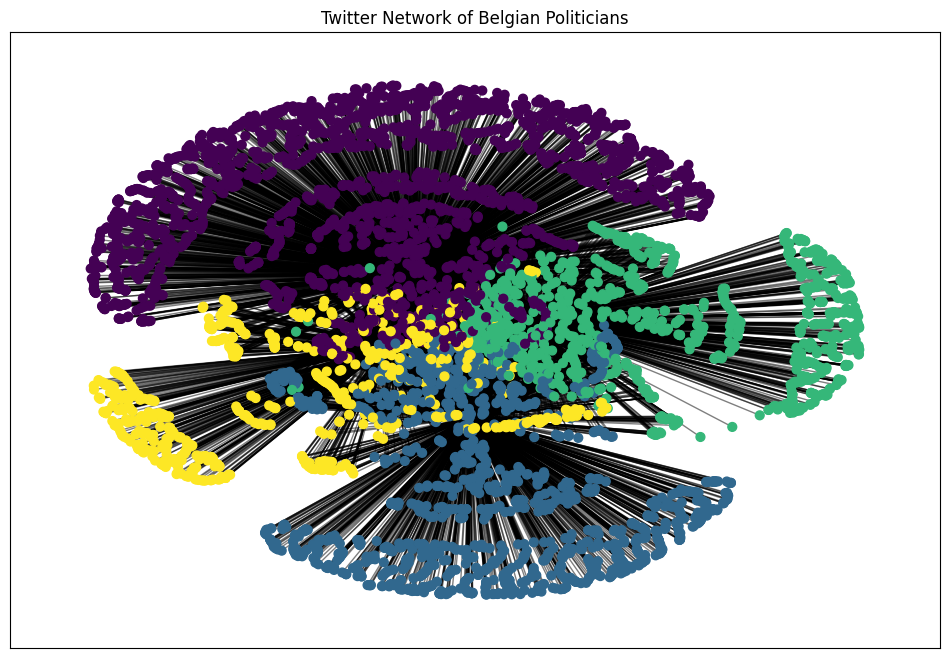

In [96]:
# Visualization
plt.figure(figsize=(12, 8))

# Draw the graph with community coloring
pos = nx.spring_layout(G)
cmap = plt.get_cmap('viridis')
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('Twitter Network of Belgian Politicians')
plt.show()

We can now perform some graph analysis to identify the importance of said users within this subgraph. We'll use centrality and betweenness measures:

In [106]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
print("Degree Centrality:")
print(degree_centrality)
print("Betweenness Centrality:")
print(betweenness_centrality)

# Find the most influential users by degree centrality
top_users_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:4]
print("Comparison of Influence (Degree Centrality):")
for user, centrality in top_users_degree:
    print(f"{user}: {centrality}")

# Find the most influential users by betweenness centrality
top_users_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:4]
print("Comparison of Influence (Betweenness Centrality):")
for user, centrality in top_users_betweenness:
    print(f"{user}: {centrality}")


Degree Centrality:
{'alexanderdecroo': 0.634582911178656, 'KDepoorterMP': 0.0005065856129685917, 'SanderLoones': 0.2701789935832489, 'Bart_DeWever': 0.23573117190138468, 'RidouaneChahid': 0.00016886187098953058, 'tomvangrieken': 0.3733535967578521, 'lalibrebe': 0.00016886187098953058, 'GLBegotique': 0.00016886187098953058, 'widged': 0.00016886187098953058, 'Sofie_Merckx': 0.00016886187098953058, 'RaoulHedebouw': 0.0006754474839581223, 'philou39377063': 0.00016886187098953058, 'wimdeceuk': 0.00016886187098953058, 'LydieNeufcourt': 0.00016886187098953058, 'JMDedecker': 0.0006754474839581223, 'Stophetfakenews': 0.0006754474839581223, 'axelledevlieger': 0.00033772374197906115, 'DeRidderRaymon1': 0.0006754474839581223, 'JohnnyDG5': 0.0006754474839581223, 'vtg73626277': 0.00033772374197906115, 'TrikkeH': 0.0005065856129685917, 'Belgonerd1': 0.0006754474839581223, 'DirkVanmeenen': 0.00033772374197906115, 'ManniJaap': 0.0005065856129685917, 'Mobru007': 0.0005065856129685917, 'fred_goris': 0.00

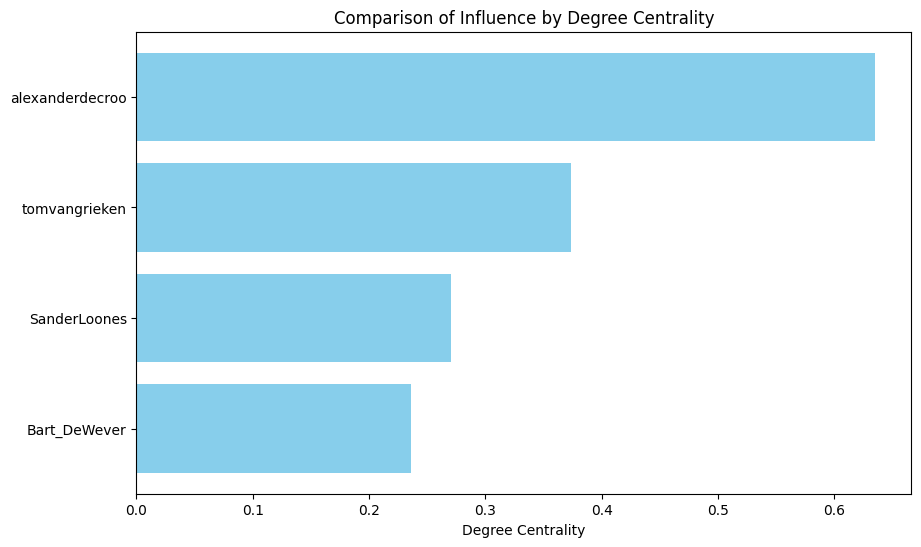

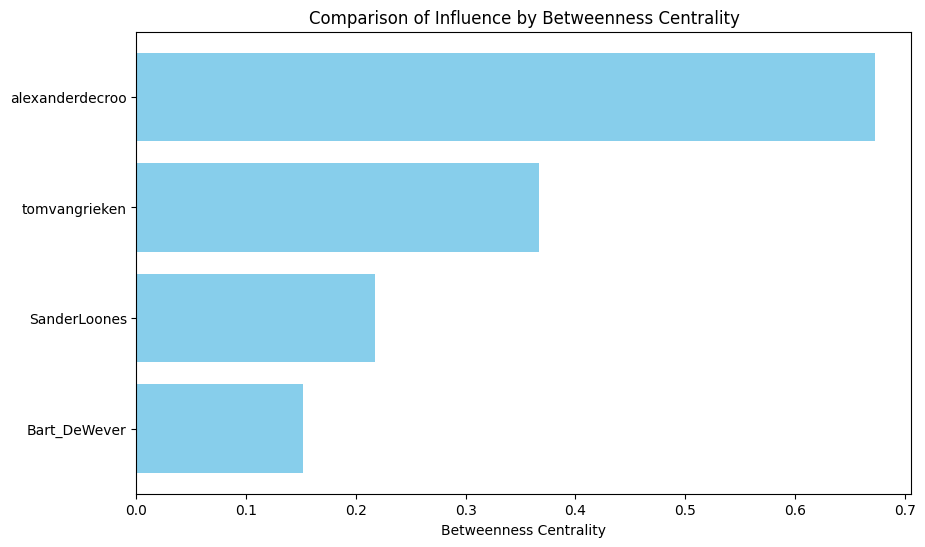

In [107]:
# Visualization of Influential Users by Degree Centrality
users_degree = [user for user, _ in top_users_degree]
centralities_degree = [centrality for _, centrality in top_users_degree]

plt.figure(figsize=(10, 6))
plt.barh(users_degree, centralities_degree, color='skyblue')
plt.xlabel('Degree Centrality')
plt.title('Comparison of Influence by Degree Centrality')
plt.gca().invert_yaxis()
plt.show()

# Visualization of Influential Users by Betweenness Centrality
users_betweenness = [user for user, _ in top_users_betweenness]
centralities_betweenness = [centrality for _, centrality in top_users_betweenness]

plt.figure(figsize=(10, 6))
plt.barh(users_betweenness, centralities_betweenness, color='skyblue')
plt.xlabel('Betweenness Centrality')
plt.title('Comparison of Influence by Betweenness Centrality')
plt.gca().invert_yaxis()
plt.show()

We can also do engagement analysis to see which users are the most engaged with 

In [108]:
# Engagement Analysis
engagement_data = defaultdict(lambda: {'replies': 0, 'retweets': 0, 'favorites': 0})
for node in G.nodes(data=True):
    screen_name = node[0]
    if 'tweets' in node[1]:
        for tweet_id, metrics in node[1]['tweets'].items():
            engagement_data[screen_name]['replies'] += metrics['reply_count']
            engagement_data[screen_name]['retweets'] += metrics['retweet_count']
            engagement_data[screen_name]['favorites'] += metrics['favorite_count']

# Convert engagement data to a list of tuples
engagement_list = [(user, data['replies'], data['retweets'], data['favorites'])
                   for user, data in engagement_data.items()]

# Sort by total engagement (replies + retweets + favorites)
sorted_engagement = sorted(engagement_list, key=lambda x: x[1] + x[2] + x[3], reverse=True)[:10]

print("Comparison of Influence by Engagement:")
for user, replies, retweets, favorites in sorted_engagement:
    print(f"{user}: Replies={replies}, Retweets={retweets}, Favorites={favorites}")


Comparison of Influence by Engagement:
alexanderdecroo: Replies=12585, Retweets=20879, Favorites=80758
tomvangrieken: Replies=8204, Retweets=18773, Favorites=49831
Bart_DeWever: Replies=6898, Retweets=7461, Favorites=28638
SanderLoones: Replies=3232, Retweets=8369, Favorites=25042


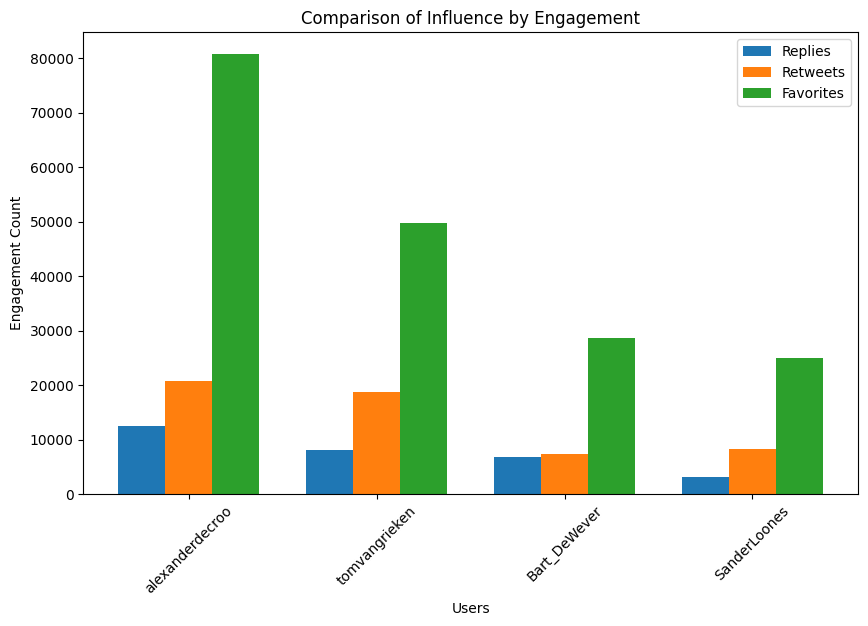

In [109]:
# Visualization of Engagement
users_eng = [user for user, _, _, _ in sorted_engagement]
replies = [replies for _, replies, _, _ in sorted_engagement]
retweets = [retweets for _, _, retweets, _ in sorted_engagement]
favorites = [favorites for _, _, _, favorites in sorted_engagement]

plt.figure(figsize=(10, 6))
bar_width = 0.25
index = range(len(users_eng))

plt.bar(index, replies, bar_width, label='Replies')
plt.bar([i + bar_width for i in index], retweets, bar_width, label='Retweets')
plt.bar([i + bar_width * 2 for i in index], favorites, bar_width, label='Favorites')

plt.xlabel('Users')
plt.ylabel('Engagement Count')
plt.title('Comparison of Influence by Engagement')
plt.xticks([i + bar_width for i in index], users_eng, rotation=45)
plt.legend()
plt.show()


We can see some interesting information obtained from this subgraph:

1. Alexander De Croo is very influential, but this comes as no surprise considering his position as Prime Minister

2. Among the other 3 influential politicians, Tom Van Grieken is visibly more influential than Bart De Wever and Sander Loones. This coincides with polls in Flanders showing that Vlaams-Belang is set to get more votes than N-VA.

3. Bart De Wever has almost as many engagements from replies than from retweets, indicating that his figure might be relatively more controversial